In [14]:
import pandas as pd
import glob
import yaml
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import logging
import os

from utils_kk.tool_functions.data_transformer import read_directory_parquet, select_RDK_parameters, rename_RDK_parameters, \
                                   generate_extra_features, retrieve_serialnumber, get_baseline_statistics, \
                                   column_info

from langchain_core.messages import HumanMessage, AIMessage

from typing import TypedDict, List
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
from utils_kk.misl_function.misl_getData import get_data
load_dotenv(override=True)


True

In [10]:
from langchain_core.messages.utils import get_buffer_string

In [15]:
chat_history = [HumanMessage(content='What is the average signal strength on the router', additional_kwargs={}, response_metadata={}, id='53966126-fcf2-4ded-b8fe-0359dc1416d8'), AIMessage(content="The average signal strength of a router can vary based on several factors, including the router's specifications, the environment in which it is placed, and the distance from connected devices. Typically, signal strength is measured in decibels (dBm), with values closer to 0 indicating a stronger signal.\n\nIf you have specific concerns about your router's performance, I would be glad to assist you further. To provide more precise assistance in the future, may I kindly request your router’s serial number?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 273, 'total_tokens': 373, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-COQ4VL3ovqPCld1CbFUpEJwn7lmBH', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run--8fa6dffd-9acc-4e65-8720-0fb0133ddab8-0', usage_metadata={'input_tokens': 273, 'output_tokens': 100, 'total_tokens': 373, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='my router number is 90100000000V412000536', additional_kwargs={}, response_metadata={}, id='3e4ffd4c-7d14-4654-9331-ba1ead587992')]

In [17]:
print(get_buffer_string(chat_history))

Human: What is the average signal strength on the router
AI: The average signal strength of a router can vary based on several factors, including the router's specifications, the environment in which it is placed, and the distance from connected devices. Typically, signal strength is measured in decibels (dBm), with values closer to 0 indicating a stronger signal.

If you have specific concerns about your router's performance, I would be glad to assist you further. To provide more precise assistance in the future, may I kindly request your router’s serial number?
Human: my router number is 90100000000V412000536


In [2]:
df = get_data()

In [4]:
df.columns.tolist()

['serialnumber',
 'date',
 'time',
 'productclass',
 'manufacturer',
 'hardware_version',
 'firmware_version',
 'hardware_reboot',
 'firmware_reboot',
 'telemetry_restart',
 'last_reboot_reason_split',
 'deviceuptime',
 'cpuusage',
 'cpu_temp_split',
 'memory_utilization',
 'flash_usage_nvram_split_perc',
 'processnumberofentries',
 'gpon_rxsignallevel',
 'gpon_txsignallevel',
 'gpon_connectionstatus',
 'gpon_operationalstate',
 'gpon_registrationstate',
 'gpon_signalfail',
 'gpon_signaldegrade',
 'wifi_radio_1_status',
 'wifi_radio_1_channel',
 'wifi_radio_1_channel_change',
 'wifi_radio_1_channelsinuse',
 'wifi_radio_1_stats_noise',
 'wifi_radio_1_stats_x_comcast_com_channelutilization',
 'wifi_radio_1_operatingchannelbandwidth',
 'wifi_radio_2_status',
 'wifi_radio_2_channel',
 'wifi_radio_2_channel_change',
 'wifi_radio_2_channelsinuse',
 'wifi_radio_2_stats_noise',
 'wifi_radio_2_stats_x_comcast_com_channelutilization',
 'wifi_radio_2_operatingchannelbandwidth',
 'wifi_accesspoint

In [20]:
df = router_data

In [38]:
with open("config/config.yaml") as file:
    var_config = yaml.safe_load(file)

router_info_params = var_config['RDK_parameters'] 

In [40]:
[i for i in df.columns if i not in router_info_params]

['last_reboot_reason_split',
 'gpon_operationalstate',
 'gpon_registrationstate',
 'gpon_txsignallevel',
 'deviceuptime',
 'ip_interface_1_lastchange',
 'ethernet_link_1_lastchange',
 'processnumberofentries',
 'wifi_ssid_1_stats_errorsreceived',
 'wifi_ssid_1_stats_packetssent',
 'wifi_ssid_1_stats_packetsreceived',
 'wifi_ssid_2_stats_errorsreceived',
 'wifi_ssid_2_stats_packetssent',
 'wifi_ssid_2_stats_packetsreceived',
 'ppp_interface_1_stats_bytessent',
 'ppp_interface_1_stats_bytesreceived',
 'ppp_interface_1_stats_errorsreceived',
 'ppp_interface_1_stats_packetssent',
 'ppp_interface_1_stats_packetsreceived',
 'ip_interface_1_stats_errorsreceived',
 'ip_interface_1_stats_packetsreceived',
 'ip_interface_1_stats_packetssent',
 'ethernet_link_1_stats_packetsreceived',
 'ethernet_link_1_stats_packetssent',
 'dsl_line_1_stats_bytessent',
 'dsl_line_1_stats_bytesreceived',
 'dsl_line_1_stats_errorsreceived',
 'dsl_line_1_stats_errorssent',
 'dsl_line_1_stats_packetsreceived',
 'dsl_

In [33]:
df.groupby(["serialnumber", "date"]).count()

time  productclass  manufacturer  \
serialnumber          date                                           
90100000000V412000536 2025-03-29    28            28            28   
                      2025-03-30    96            96            96   
                      2025-03-31    95            95            95   
                      2025-04-01    95            95            95   
                      2025-04-02    95            95            95   
...                                ...           ...           ...   
901A0000000V503014579 2025-09-26    58            58            58   
                      2025-09-27    61            61            61   
                      2025-09-28    68            68            68   
                      2025-09-29    74            74            74   
                      2025-09-30    82            82            82   

                                  hardwareversion  version  \
serialnumber          date                                   
90100000000V412000536 2025-03-29               28       28   
                      2025-03-30               96       96   
                      2025-03-31               95       95   
                      2025-04-01               95       95   
                      2025-04-02               95       95   
...                                           ...      ...   
901A0000000V503014579 2025-09-26               58       58   
                      2025-09-27               61       61   
                      2025-09-28               68       68   
                      2025-09-29               74       74   
                      2025-09-30               82       82   

                                  last_reboot_reason_split  telemetry_restart  \
serialnumber          date                                                      
90100000000V412000536 2025-03-29                        28                  0   
                      2025-03-30                        96                  0   
                      2025-03-31                        95                  0   
                      2025-04-01                        95                  0   
                      2025-04-02                        95                  0   
...                                                    ...                ...   
901A0000000V503014579 2025-09-26                        58                  0   
                      2025-09-27                        61                  0   
                      2025-09-28                        68                  1   
                      2025-09-29                        74                  0   
                      2025-09-30                        82                  0   

                                  wifi_accesspoint_1_status  \
serialnumber          date                                    
90100000000V412000536 2025-03-29                         28   
                      2025-03-30                         96   
                      2025-03-31                         95   
                      2025-04-01                         95   
                      2025-04-02                         95   
...                                                     ...   
901A0000000V503014579 2025-09-26                         58   
                      2025-09-27                         61   
                      2025-09-28                         68   
                      2025-09-29                         74   
                      2025-09-30                         82   

                                  wifi_accesspoint_2_status  \
serialnumber          date                                    
90100000000V412000536 2025-03-29                         28   
                      2025-03-30                         96   
                      2025-03-31                         95   
                      2025-04-01                         95   
                      2025-04-02                         95   
.

In [17]:
router_data

,variable,mean,min,max,p95,q1,q3,iqr,lower_fence,upper_fence
0,wifi_radio_2_stats_noise,-92.958436,-99.000000,0.000000,0.000000,-99.000000,-99.000000,0.000000,-99.000000,-99.000000
1,wifi_radio_1_stats_x_comcast_com_channelutiliz...,32.835349,0.000000,35.000000,35.000000,35.000000,35.000000,0.000000,35.000000,35.000000
2,flash_usage_nvram_split_perc,0.165200,0.145833,0.987963,0.176852,0.159259,0.165741,0.006482,0.149537,0.175463
3,wifi_radio_2_stats_x_comcast_com_channelutiliz...,32.862204,0.000000,35.000000,35.000000,35.000000,35.000000,0.000000,35.000000,35.000000
4,wifi_radio_1_operatingchannelbandwidth,39.961268,20.000000,40.000000,40.000000,40.000000,40.000000,0.000000,40.000000,40.000000
5,wifi_radio_1_stats_noise,-92.882550,-99.000000,0.000000,0.000000,-99.000000,-99.000000,0.000000,-99.000000,-99.000000
6,signalstrength_avg,-58.203375,-109.000000,214.571429,-39.000000,-65.076923,-52.500000,12.576923,-83.942308,-33.634615
7,gpon_rxsignallevel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,memory_utilization,92.181265,72.600000,97.100000,94.800000,90.600000,94.300000,3.700000,85.050000,99.850000
9,downlink_rate_avg,543.550581,0.000000,4803.000000,1282.000000,194.285714,780.000000,585.714286,-684.285714,1658.571429


## 1. Get DATA in memory

In [3]:
llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_API_BASE"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("OPENAI_API_VERSION"),
    # max_tokens=500,
    temperature=0,
    deployment_name=os.getenv('AZURE_OPENAI_DEPLOYMENT_NAME'),
    model_name=os.getenv('AZURE_OPENAI_ASSISTANT_MODEL'),
)

In [1]:
from utils_kk.misl_function.misl_getData import get_data
from langgraph.graph import StateGraph, MessagesState
from langgraph.graph import START, END
from langgraph.checkpoint.memory import MemorySaver
from utils_kk.nodes.node_intentClassification import intent_classification_node
from utils_kk.variables.variable_definitions import customGraph
from utils_kk.nodes.node_chitchat import chit_chat_agent, validate_chit_chat, merge_answer
from utils_kk.nodes.node_rca import rca_agent
from utils_kk.branching.branch_control import intent_classification_branch, chit_chat_branch
from dotenv import load_dotenv

## 2. Create Agent State

In [6]:
from main import create_graph
flow = create_graph()

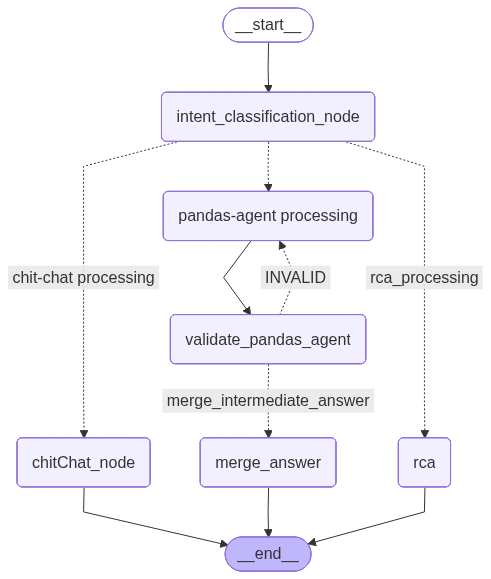

In [7]:
flow

In [4]:
from langgraph.graph import StateGraph, MessagesState
from langgraph.graph import START, END
from utils_kk.nodes.node_intentClassification import intent_classification_node
from utils_kk.variables.variable_definitions import customGraph
from utils_kk.nodes.node_chitchat import chit_chat_agent
from utils_kk.nodes.node_rca import rca_agent

In [5]:
def intent_classification_branch(state: customGraph):

    intent = state["intent_classification"]
    if intent == "rca":
        return "rca_processing"

    elif intent == "chit-chat":
        return "chit-chat processing"

In [2]:
def create_graph():
    graph = StateGraph(state_schema=customGraph)
    graph.add_node("intent_classification_node", intent_classification_node)
    graph.add_edge(START, "intent_classification_node")
    graph.add_conditional_edges("intent_classification_node", intent_classification_branch, 
                               {"rca_processing": "rca", "chit-chat processing": "chit-chat"})

    ## Flow-1
    graph.add_node("chit-chat", chit_chat_agent)
    graph.add_node("validate_chit_chat", validate_chit_chat)
    graph.add_node("merge_answer", merge_answer)
    graph.add_edge("chit-chat", "validate_chit_chat")
    graph.add_conditional_edges("validate_chit_chat", chit_chat_branch,
                                {"VALID": "merge_answer", "INVALID": "chit-chat"}
    )
    graph.add_edge("merge_answer", END)
    
    ## Flow-2
    graph.add_node("rca", rca_agent)
    graph.add_edge("rca", END)

    store = MemorySaver()
    flow = graph.compile()
    return flow

In [3]:
flow = create_graph()

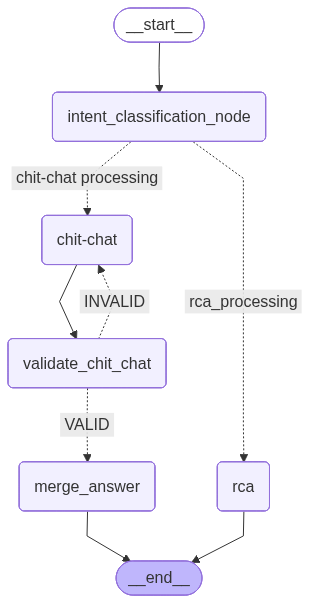

In [4]:
flow

In [5]:
flow = create_graph()

NameError: name 'create_graph' is not defined

In [10]:
response = flow.invoke({
        "question": "What is the avergae CPU Usage for 90100000000V412000536?", 
        "data": router_data
    })

2025-09-30 21:56:29 [debug    ] -- From intent classification node detail='What is the avergae CPU Usage for 90100000000V412000536?'
2025-09-30 21:56:31 [debug    ] -- Intent classification node  detail={'intent': 'chit-chat'}
2025-09-30 21:56:31 [debug    ] -- From chitchat node          detail='What is the avergae CPU Usage for 90100000000V412000536?'


> Entering new AgentExecutor chain...


/Users/A118390615/Library/CloudStorage/OneDrive-DeutscheTelekomAG/Projects/bb_troubleshooter_chatbot/utils_kk/nodes/node_chitchat.py:25: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
/Users/A118390615/Library/CloudStorage/OneDrive-DeutscheTelekomAG/Projects/bb_troubleshooter_chatbot/.venv/lib/python3.13/site-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'memory': ConversationBufferMemory(chat_memory=InMemoryChatMessageHistory(messages=[]), return_messages=True, memory_key='chat_history')} which are no longer supported.
  warnings.warn(



Invoking: `python_repl_ast` with `{'query': "average_cpu_usage = df[df['serialnumber'] == '90100000000V412000536']['cpuusage'].mean()\naverage_cpu_usage"}`


23.118754707506906The average CPU usage for the serial number `90100000000V412000536` is approximately 23.12%.

> Finished chain.


In [ ]:
response['final_result']    

'The average CPU usage for the serial number `90100000000V412000536` is approximately 23.12%.'

In [22]:
graph_compiled = graph.compile()

In [23]:
graph_compiled.invoke({"question": "What was the root cause of the reboot at 2024-08-02 20:07:00?"})

2025-09-30 20:34:18 [debug    ] -- From intent classification node detail='What was the root cause of the reboot at 2024-08-02 20:07:00?'
2025-09-30 20:34:19 [debug    ] -- Intent classification node  detail={'intent': 'rca'}
2 validation errors for AIMessage
content.str
  Input should be a valid string [type=string_type, input_value={'intent': 'rca'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]]
  Input should be a valid list [type=list_type, input_value={'intent': 'rca'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/list_type


IndexError: list index out of range

In [10]:
def intent_classification_node(state: customGraph):

    if state.get("bypass_intention", None):
        structlogger.error("ByPassing intent classification")
        return {"generation_scratchpad": [AIMessage(content=response)]}

    else:
        query = state.get("question", None)
        structlogger.debug("-- From intent classification node", detail=query)
        output_format = PydanticOutputParser(
            pydantic_object = IntentClassification).get_format_instructions()
        intent_classification_prompt = PromptTemplate(template=intent_classification_template,
                                                      partial_variables={
            "output_parser": output_format                                                                     
        })
        chain = intent_classification_prompt | llm | JsonOutputParser()

        try:
            for trial in range(int(os.getenv("num_retries", None))):
                response = chain.invoke(input={"user_query": query})
                if isinstance(response, dict):
                    if "intent" in response:
                        state["intent_classification"] = response["intent"]
                        structlogger.debug("-- Intent classification node", detail=response)
                        return {"generation_scratchpad": [AIMessage(content=json.dumps(response))]}
                        
                else:
                    structlogger.error("Wrong schema recieved", detail=response)
        except Exception as e:
            print(e)

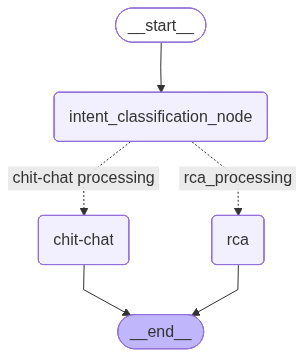

In [40]:
graph_compiled

In [23]:
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.memory.buffer import ConversationBufferMemory

In [33]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
agent = create_pandas_dataframe_agent(llm, 
                                      router_data, 
                                      verbose=True, 
                                      agent_type="openai-tools", 
                                      allow_dangerous_code=True,
                                      memory=memory)

/Users/A118390615/Library/CloudStorage/OneDrive-DeutscheTelekomAG/Projects/bb_troubleshooter_chatbot/.venv/lib/python3.13/site-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'memory': ConversationBufferMemory(chat_memory=InMemoryChatMessageHistory(messages=[]), return_messages=True, memory_key='chat_history')} which are no longer supported.
  warnings.warn(


In [31]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=[], memory=ConversationBufferMemory())

In [34]:
result = agent.invoke("What is the average CPU Usage for 90100000000V412000536?")



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "average_cpu_usage = df[df['serialnumber'] == '90100000000V412000536']['cpuusage'].mean()\naverage_cpu_usage"}`


23.118754707506906The average CPU usage for the serial number `90100000000V412000536` is approximately 23.12%.

> Finished chain.


In [22]:
result

{'input': 'What is the average CPU Usage for 90100000000V412000536?',
 'output': 'The average CPU usage for the serial number `90100000000V412000536` is approximately 23.12%.'}

,serialnumber,date,time,productclass,manufacturer,hardware_version,firmware_version,telemetry_restart,wifi_accesspoint_1_status,wifi_accesspoint_2_status,...,downlink_rate_min,downlink_rate_max,downlink_rate_avg,uplink_rate_min,uplink_rate_max,uplink_rate_avg,total_band_change,timestamp,wifi_radio_1_total_channels_active,wifi_radio_2_total_channels_active
254439,90100000000V412000536,2025-09-23,2025-09-23 23:59:13,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 23:59:13,1,8
361071,90100000000V412000536,2025-09-23,2025-09-23 23:44:05,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 23:44:05,1,8
53601,90100000000V412000536,2025-09-23,2025-09-23 23:28:56,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 23:28:56,1,8
316678,90100000000V412000536,2025-09-23,2025-09-23 23:13:45,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 23:13:45,1,8
98051,90100000000V412000536,2025-09-23,2025-09-23 22:58:37,DT-HGW01A-ARC,Arcadyan,01,004.011.078,0,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-09-23 22:58:37,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218248,90100000000V412000536,2025-03-29,2025-03-29 18:04:19,DT-HGW01A-ARC,Arcadyan,01,004.011.052,0,Enabled,Enabled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-29 18:04:19,1,8
44257,90100000000V412000536,2025-03-29,2025-03-29 17:49:19,DT-HGW01A-ARC,Arcadyan,01,004.011.052,0,Enabled,Enabled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-29 17:49:19,1,8
70925,90100000000V412000536,2025-03-29,2025-03-29 17:34:19,DT-HGW01A-ARC,Arcadyan,01,004.011.052,0,Enabled,Enabled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-29 17:34:19,1,8
62069,90100000000V412000536,2025-03-29,2025-03-29 17:19:19,DT-HGW01A-ARC,Arcadyan,01,004.011.052,0,Enabled,Enabled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-29 17:19:19,1,8


In [48]:
router_data

,serialnumber,date,time,productclass,manufacturer,hardwareversion,version,last_reboot_reason_split,telemetry_restart,wifi_accesspoint_1_status,...,max_signalstrength,avg_signalstrength,min_lastdatadownlinkrate,max_lastdatadownlinkrate,avg_lastdatadownlinkrate,min_lastdatauplinkrate,max_lastdatauplinkrate,avg_lastdatauplinkrate,n_devices,total_band_change
0,90100000000V412000536,2025-03-30,2025-03-30 11:12:51,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-52.0,-62.833333,6.0,1921.0,569.166667,1.0,1152.0,478.000000,6.0,0.0
1,90100000000V412000536,2025-03-31,2025-03-31 04:43:23,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-53.0,-65.000000,11.0,1297.0,406.600000,6.0,1152.0,376.600000,5.0,0.0
2,90100000000V412000536,2025-03-31,2025-03-31 14:28:23,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-53.0,-62.000000,65.0,390.0,251.666667,52.0,433.0,211.666667,3.0,0.0
3,90100000000V412000536,2025-04-01,2025-04-01 06:28:12,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-52.0,-64.500000,65.0,2161.0,721.500000,26.0,1729.0,549.250000,4.0,0.0
4,90100000000V412000536,2025-04-01,2025-04-01 20:43:13,DT-HGW01A-ARC,Arcadyan,01,004.011.052,unknown,None,Enabled,...,-52.0,-66.750000,6.0,1297.0,439.500000,26.0,864.0,536.000000,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369397,901A0000000V503014579,2025-09-16,2025-09-16 00:03:01,DT-HGW01A-ARC,Arcadyan,03,004.011.078,powerloss-reboot,None,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369398,901A0000000V503014579,2025-09-17,2025-09-17 08:29:06,DT-HGW01A-ARC,Arcadyan,03,004.011.078,powerloss-reboot,None,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369399,901A0000000V503014579,2025-09-17,2025-09-17 17:46:36,DT-HGW01A-ARC,Arcadyan,03,004.011.078,powerloss-reboot,None,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369400,901A0000000V503014579,2025-09-18,2025-09-18 09:45:52,DT-HGW01A-ARC,Arcadyan,03,004.011.078,powerloss-reboot,None,Enabled;Enabled;Enabled;Enabled;Enabled;Enable...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
for file_name in glob.glob('datapoints/DE_router_data/DE_baseline_router_data/*.parquet'):
    print(file_name)

'../datapoints/DE_router_data/DE_baseline_router_data/'